# IMDB Movie Review Analysis


## 실습 목표
----
- 자연어 처리를 위한 주요 신경망의 사용법을 이해한다.
- 영화 리뷰평의 긍정/부정을 판단하기 위한 감정분석 분류 모델을 생성한다.
- 데이터셋: [imdb](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) 전처리 완료 데이터

## 문제 정의
----
- binary classifier(positive or negative)

## 주요 코드
----

### 1. RNN의 유형

![RNN-Relations](https://raw.githubusercontent.com/fhrzn/all-about-rnn/master/sentiment-analysis/notebook/images/diags.jpeg)

- **many to one**
    - 영화 리뷰 텍스트(many)를 입력으로 받아 긍정 또는 부정(one)을 출력하는 구조
    - **Embedding**: 영화 리뷰(text)를 벡터로 변환하는 연산
    - **LSTM**: 시계열 데이터를 처리하기 위한 구조
    - **Linear**: 결과 출력

**모델 구조 미리보기**
```
LSTMClassifier(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
```

**torch.nn.LSTM**
* Parameters
    * input_size
    * hidden_size
    * num_layers
    * dropout
    * batch_first
    * bidirectional
* Inputs: input, (h_0, c_0)
    * input shape
        * (L, N, H_in) : `batch_size=False`
        * (N, L, H_in) : `batch_size=True`

* Outputs: output, (h_n, c_n)
    * output shape
        * (L, N, D*H_out) : `batch_size=False`
        * (N, L, D*H_out) : `batch_size=True`

----
- **N**: batch size
- **L**: sequence length
- **D**: 2(bidirectional) or 1
- **H_in**: input_size
- **H_cell**: hidden_size
- **H_out**: proj_size or hidden_size

```
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size=400):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 512, 2, dropout=0.25, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o
```

### 2. 텍스트 데이터 전처리

텍스트를 벡터로 변환하는 작업
0. 원본
    - one reviewer mentioned watching oz episode hooked
1. **사전 생성**
    - 리뷰 문장에 들어있는 단어들을 추출하고, 각각의 단어에 숫자를 부여하는 작업
    - ['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'hooked']

2. 리뷰**인코딩**
    - 리뷰에 포함된 단어를 숫자형태로 변환하는 작업
    -  {'i': 1, 'movie': 2, 'film': 3, 'the': 4, 'one': 5, 'like': 6, 'it': 7, 'time': 8, 'this': 9, 'good': 10, 'character': 11,...}    
    - [5, 1095, 972, 74, 2893, 186, 2982, 119, 114, 538]
3. **길이 맞춰주기**: padding or trim
    - 신경망의 입력으로 사용하기 위에 일정 길이만큼 맞춰주는 작업
    - 길이가 긴 문장은 잘라주고(trim), 길이가 짧은 문장은 채워주는(padding) 작업
    - [[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118, 114],<br>
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875, 4],<br>
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633, 2],...]

4. **학습용, 테스트용 분할**
5. **데이터 로더 생성**

### 3. tqdm

- iterable을 감싸서 진행률을 표시할 때 사용
- 학습 과정의 iteration에서 진행률을 표시할 때 사용

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.05)
    pass

100%|██████████| 100/100 [00:05<00:00, 19.22it/s]


**tqdm parameter**
* itereable: 반복자
* desc: 진행바 앞에 텍스트 출력
* leave: 진행상태를 남겨둘지 여부

```
# train loop
epochloop = tqdm(range(epochs), desc='Training')
```

### 4. Early stop

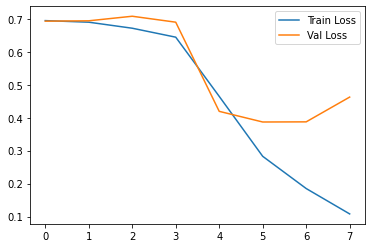
```
es_trigger = 0
es_limit = 5

for e in epochloop:
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = validation(model, valloader)
    
    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:       
        es_trigger += 1

    # early stop
    if es_trigger >= es_limit:
        break
```

## Sentimental Analysis
----

#### [Step1] Load libraries & Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter #데이터 전처리에 사용

In [ ]:
# %cd /content/drive/MyDrive/github/deeplearning

/content/drive/MyDrive/github/deeplearning


In [3]:
data = pd.read_csv('exercise4.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [4]:
#소문자로 변경, 특수기호를 모두 공백으로
data['processed'] = data['processed'].str.lower().replace(r"[^a-zA-Z ]", "", regex=True)

In [5]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

##### 사전생성

In [6]:
# 문장에 포함된 단어 토큰화
reviews = data['processed'].values
words = ' '.join(reviews).split()
words[:10]

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'they',
 'right',
 'exactly']

In [7]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>' #값을 넣어주기위한 구문이야
word2int = {word: id for id, word in int2word.items()}
word2int

{'i': 1,
 'movie': 2,
 'film': 3,
 'the': 4,
 'one': 5,
 'like': 6,
 'it': 7,
 'time': 8,
 'this': 9,
 'good': 10,
 'character': 11,
 'story': 12,
 'even': 13,
 'get': 14,
 'would': 15,
 'make': 16,
 'see': 17,
 'really': 18,
 'scene': 19,
 'well': 20,
 'much': 21,
 'bad': 22,
 'people': 23,
 'great': 24,
 'also': 25,
 'first': 26,
 'show': 27,
 'way': 28,
 'made': 29,
 'thing': 30,
 'could': 31,
 'life': 32,
 'think': 33,
 'go': 34,
 'but': 35,
 'know': 36,
 'watch': 37,
 'and': 38,
 'love': 39,
 'plot': 40,
 'two': 41,
 'actor': 42,
 'many': 43,
 'seen': 44,
 'a': 45,
 'say': 46,
 'year': 47,
 'never': 48,
 'end': 49,
 'acting': 50,
 'look': 51,
 'best': 52,
 'little': 53,
 'in': 54,
 'there': 55,
 'ever': 56,
 'man': 57,
 'better': 58,
 'take': 59,
 'if': 60,
 'come': 61,
 'work': 62,
 'still': 63,
 'he': 64,
 'part': 65,
 'something': 66,
 'find': 67,
 'director': 68,
 'want': 69,
 'back': 70,
 'give': 71,
 'lot': 72,
 'real': 73,
 'watching': 74,
 'guy': 75,
 'performance': 76,
 '

##### 리뷰 인코딩

In [8]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:01<00:00, 28173.76it/s]


In [9]:
reviews_enc[0][:10]

[5, 1095, 972, 74, 2893, 186, 2982, 119, 114, 538]

In [10]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [11]:
word2int['one'], word2int['reviewer'], word2int['mentioned']

(5, 1095, 972)

In [12]:
data['encoded'] = reviews_enc

##### 길이 맞춰주기

In [13]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)  # np.full((5, 3), 2)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

In [14]:
labels = data['label'].to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

##### 데이터 분할

In [15]:
# train test split
train_size = .8
split_id = int(len(features) * train_size)
train_x, test_x, train_y, test_y = features[:split_id], features[split_id:], labels[:split_id], labels[split_id:]

split_id = int(len(train_x) * train_size)
train_x, valid_x, train_y, valid_y = train_x[:split_id], train_x[split_id:], train_y[:split_id], train_y[split_id:]
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_x.shape, valid_x.shape, test_x.shape))
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_y.shape, valid_y.shape, test_y.shape))

Train shape:(32000, 256), Valid shape: (8000, 256), Test shape: (10000, 256)
Train shape:(32000,), Valid shape: (8000,), Test shape: (10000,)


#### [Step2] Create DataLoader

In [16]:
# set hyperparameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 0.001
batch_size = 128
vocab_size = len(word2int)
embedding_size = 256
dropout=0.25

epochs = 8
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

cuda


In [17]:
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

#### [Step3] Set Network Structure

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size=400):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size) #vocab_size : 앞에서 만든 사전 길이 -> embedding_size
        self.lstm = nn.LSTM(embedding_size, 512, 2, dropout=0.25, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o

#### [Step4] Create Model instance

In [19]:
model = LSTMClassifier(vocab_size, embedding_size).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(96140, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### [Step5] Model compile

In [20]:
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)

#### [Step6] Set train loop

In [21]:
def train(model, trainloader):
    model.train()

    train_loss = 0
    train_acc = 0

    for id, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.squeeze(), y.float())
        loss.backward()
        optim.step()

        train_loss += loss.item()
        y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
        equals = y_pred == y
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    return train_loss, train_acc

#### [Step7] Set test loop

In [22]:
def validation(model, valloader):
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (X, y) in enumerate(valloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y.float())

            val_loss += loss.item()

            y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
            equals = y_pred == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    return val_loss, val_acc

#### [Step8] Run model

In [27]:
# train loop
epochloop = tqdm(range(epochs), desc='Training')

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = validation(model, valloader)
    epochloop.write(f'Epoch[{e+1}/{epochs}] Train Loss: {train_loss / len(trainloader):.3f}, Train Acc: {train_acc / len(trainloader):.3f}, Val Loss: {val_loss / len(valloader):.3f}, Val Acc: {val_acc / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        es_trigger += 1

    # early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:   0%|          | 0/8 [01:01<?, ?it/s]

Epoch[1/8] Train Loss: 0.638, Train Acc: 0.600, Val Loss: 0.649, Val Acc: 0.600


Training:  12%|█▎        | 1/8 [02:06<07:15, 62.15s/it]

Epoch[2/8] Train Loss: 0.393, Train Acc: 0.829, Val Loss: 0.373, Val Acc: 0.844


Training:  25%|██▌       | 2/8 [03:12<06:22, 63.75s/it]

Epoch[3/8] Train Loss: 0.241, Train Acc: 0.909, Val Loss: 0.345, Val Acc: 0.859


Training:  50%|█████     | 4/8 [04:19<04:21, 65.50s/it]

Epoch[4/8] Train Loss: 0.165, Train Acc: 0.944, Val Loss: 0.389, Val Acc: 0.859


Training:  62%|██████▎   | 5/8 [05:27<03:18, 66.17s/it]

Epoch[5/8] Train Loss: 0.111, Train Acc: 0.968, Val Loss: 0.379, Val Acc: 0.866


Training:  75%|███████▌  | 6/8 [06:35<02:13, 66.82s/it]

Epoch[6/8] Train Loss: 0.074, Train Acc: 0.981, Val Loss: 0.444, Val Acc: 0.856


Training:  88%|████████▊ | 7/8 [07:43<01:07, 67.24s/it]

Epoch[7/8] Train Loss: 0.058, Train Acc: 0.986, Val Loss: 0.496, Val Acc: 0.860


Training:  88%|████████▊ | 7/8 [08:51<01:15, 75.91s/it]

Epoch[8/8] Train Loss: 0.044, Train Acc: 0.990, Val Loss: 0.556, Val Acc: 0.857
Early stopped at Epoch-8


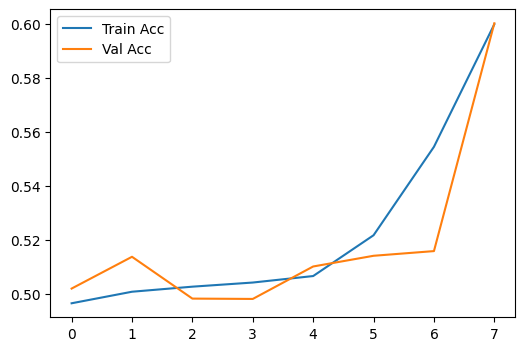

In [32]:
# plot loss
plt.figure(figsize=(6, 4))
plt.plot(range(history['epochs']), history['train_acc'][0:8], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'][0:8], label='Val Acc')
plt.legend()
plt.show()

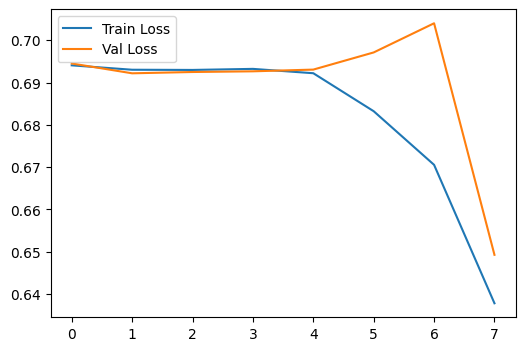

In [33]:
# plot loss
plt.figure(figsize=(6, 4))
plt.plot(range(history['epochs']), history['train_loss'][0:8], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'][0:8], label='Val Loss')
plt.legend()
plt.show()

- References:
    - [Udacity - Introduction to PyTorch](https://classroom.udacity.com/courses/ud188)
    - [The Unreasonable Effectiveness of RNNs by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    - [PyTorch Name Classification project](https://github.com/python-engineer/pytorch-examples/tree/master/rnn-name-classification)
    - [My exploration project in RNNs](https://github.com/fhrzn/all-about-rnn)